# 利用 AWS Sagemaker BlazingText 对不均衡文本进行多分类

## baseline实验

Step 0 - Setup；
Step 1 - 数据集分析；
Step 2 - 数据预处理；

# Step 0 - Setup

指定用于存放训练和模型数据的S3存储桶和前缀。 

并指定 IAM 角色用于授予SageMaker访问数据的权限。 

In [1]:
import sagemaker
from sagemaker import get_execution_role
import json
import boto3

sess = sagemaker.Session()

role = get_execution_role()
print(role)

bucket = 'sagemaker-workshop-demos'
prefix = 'unbalanced-text-multi-classification'

arn:aws:iam::528326054333:role/service-role/AmazonSageMaker-ExecutionRole-20190827T175137


# Step 1 - 数据集分析

In [2]:
import pandas as pd

step1_df = pd.read_csv('original_dataset/dataset.csv')
print("行数：" + str(step1_df.shape[0]))
step1_df.head()

行数：188020


,label,title,abstract
0,1,E. D. Abbott Ltd,Abbott of Farnham E D Abbott Limited was a Br...
1,1,Schwan-Stabilo,Schwan-STABILO is a German maker of pens for ...
2,1,Q-workshop,Q-workshop is a Polish company located in Poz...
3,1,Marvell Software Solutions Israel,Marvell Software Solutions Israel known as RA...
4,1,Bergan Mercy Medical Center,Bergan Mercy Medical Center is a hospital loc...


In [3]:
# 查看一共有哪些类别以及每个类别数据的数量分布情况

count_classes = pd.value_counts(step1_df['label'], sort = True)
print(count_classes)

1     40000
2     38000
3     18000
4     17000
5     16000
6     15000
7     14000
8     13000
9      8000
10     5000
11     3000
12      900
13      100
14       20
Name: label, dtype: int64


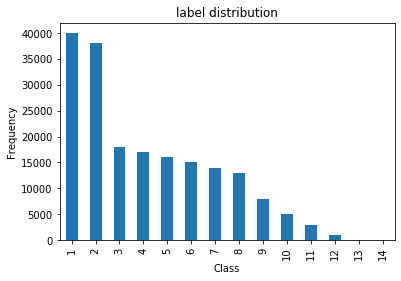

In [4]:
# 类别分布图

import matplotlib.pyplot as plt

count_classes = step1_df.label.value_counts()
count_classes.plot(kind = 'bar')
plt.title("label distribution")
plt.xlabel("Class")
plt.ylabel("Frequency");

In [5]:
# 查看数字类别对应的名称

!cat original_dataset/classes.txt

Company
EducationalInstitution
Artist
Athlete
OfficeHolder
MeanOfTransportation
Building
NaturalPlace
Village
Animal
Plant
Album
Film
WrittenWork


In [6]:
# 创建从整数索引到类标签的字典映射

index_to_label = {} 
with open("original_dataset/classes.txt") as f:
    for i,label in enumerate(f.readlines()):
        index_to_label[str(i+1)] = label.strip()
print(index_to_label)

{'1': 'Company', '2': 'EducationalInstitution', '3': 'Artist', '4': 'Athlete', '5': 'OfficeHolder', '6': 'MeanOfTransportation', '7': 'Building', '8': 'NaturalPlace', '9': 'Village', '10': 'Animal', '11': 'Plant', '12': 'Album', '13': 'Film', '14': 'WrittenWork'}


## Step 2 - 数据预处理

1.去掉空行；2.大小写统一；3.分词；4.转化为BlazingText的数据集格式

预处理后的数据集已经可以作为Baseline实验的数据集

In [7]:
from random import shuffle
import multiprocessing
from multiprocessing import Pool
import csv
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
# 创建从整数索引到以“__label__”开头的类标签的字典映射

index_to_label_final = {}
for key in index_to_label:
    index_to_label_final[key] = "__label__" + str(index_to_label[key]) 

print(index_to_label_final) 

{'1': '__label__Company', '2': '__label__EducationalInstitution', '3': '__label__Artist', '4': '__label__Athlete', '5': '__label__OfficeHolder', '6': '__label__MeanOfTransportation', '7': '__label__Building', '8': '__label__NaturalPlace', '9': '__label__Village', '10': '__label__Animal', '11': '__label__Plant', '12': '__label__Album', '13': '__label__Film', '14': '__label__WrittenWork'}


In [10]:

def tokenize(series):
    for index, value in series.items():
        series[index] = nltk.word_tokenize(value.lower())
    return series

def preprocess(step1_df):
    
    step1_df = step1_df.dropna(axis=0) 
    
    step2_df = pd.DataFrame()
    step2_df['label'] = step1_df['label']
    step2_df['label'] = step2_df['label'].map(str).map(index_to_label_final)
    step2_df['sentence'] = step1_df["title"].map(str) +","+ step1_df["abstract"].map(str)
#     step2_df['sentence'] = tokenize(step2_df['sentence'])
    return step2_df

step2_df = preprocess(step1_df)
step2_df.head(10)

,label,sentence
0,__label__Company,"E. D. Abbott Ltd, Abbott of Farnham E D Abbott..."
1,__label__Company,"Schwan-Stabilo, Schwan-STABILO is a German mak..."
2,__label__Company,"Q-workshop, Q-workshop is a Polish company loc..."
3,__label__Company,"Marvell Software Solutions Israel, Marvell Sof..."
4,__label__Company,"Bergan Mercy Medical Center, Bergan Mercy Medi..."
5,__label__Company,"The Unsigned Guide, The Unsigned Guide is an o..."
6,__label__Company,"Rest of the world, Within sports and games pla..."
7,__label__Company,"Globoforce, Globoforce is a multinational comp..."
8,__label__Company,"Rompetrol, The Rompetrol Group N.V. is a Roman..."
9,__label__Company,"Wave Accounting, Wave is the brand name for a ..."


In [11]:
# 预处理后的数据集作为baseline实验的数据集

step2_df.to_csv("baseline_dataset/dataset_baseline.csv", sep=" ", header=0, index=0)

## Step3 - 模型训练

对原始样本进行文本分类模型的训练。

算法选择Sagemaker预置的BlazingText算法中的指导型文本分类模式。

In [13]:
# 划分训练集和测试集

import numpy as np
from sklearn.model_selection import train_test_split

baseline_train, baseline_test = train_test_split(step2_df, test_size=0.15)
baseline_train.to_csv("baseline_dataset/baseline_train.csv", sep=" ", header=0, index=0)
baseline_test.to_csv("baseline_dataset/baseline_test.csv", sep=" ", header=0, index=0)

In [14]:
# 上传数据到 S3

train_channel = prefix + '/baseline' + '/train'
validation_channel = prefix + '/baseline' + '/validation'

sess.upload_data(path='baseline_dataset/baseline_train.csv', bucket=bucket, key_prefix=train_channel)
sess.upload_data(path='baseline_dataset/baseline_test.csv', bucket=bucket, key_prefix=validation_channel)

s3_train_data = 's3://{}/{}'.format(bucket, train_channel)
s3_validation_data = 's3://{}/{}'.format(bucket, validation_channel)

In [15]:
s3_output_location = 's3://{}/{}/baseline/output'.format(bucket, prefix)

In [16]:
region_name = boto3.Session().region_name

In [17]:
container = sagemaker.amazon.amazon_estimator.get_image_uri(region_name, "blazingtext", "latest")
print('Using SageMaker BlazingText container: {} ({})'.format(container, region_name))

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


Using SageMaker BlazingText container: 501404015308.dkr.ecr.ap-northeast-1.amazonaws.com/blazingtext:latest (ap-northeast-1)


In [18]:
baseline_model = sagemaker.estimator.Estimator(container,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.c4.4xlarge',
                                         train_volume_size = 30,
                                         train_max_run = 360000,
                                         input_mode= 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [19]:
baseline_model.set_hyperparameters(mode="supervised",
                            epochs=10,
                            min_count=2,
                            learning_rate=0.05,
                            vector_dim=10,
                            early_stopping=True,
                            patience=4,
                            min_epochs=5,
                            word_ngrams=2)

In [20]:
train_data = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', 
                        content_type='text/plain', s3_data_type='S3Prefix')

validation_data = sagemaker.session.s3_input(s3_validation_data, distribution='FullyReplicated', 
                             content_type='text/plain', s3_data_type='S3Prefix')

data_channels = {'train': train_data, 'validation': validation_data}

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [21]:
# 过采样后的模型训练

baseline_model.fit(inputs=data_channels, logs=True)

2020-08-14 08:57:11 Starting - Starting the training job...
2020-08-14 08:57:14 Starting - Launching requested ML instances......
2020-08-14 08:58:30 Starting - Preparing the instances for training......
2020-08-14 08:59:27 Downloading - Downloading input data
2020-08-14 08:59:27 Training - Downloading the training image.Arguments: train
[08/14/2020 08:59:43 WARNING 140473558898496] Loggers have already been setup.
[08/14/2020 08:59:43 WARNING 140473558898496] Loggers have already been setup.
[08/14/2020 08:59:43 INFO 140473558898496] nvidia-smi took: 0.0252330303192 secs to identify 0 gpus
[08/14/2020 08:59:43 INFO 140473558898496] Running single machine CPU BlazingText training using supervised mode.
[08/14/2020 08:59:43 INFO 140473558898496] Processing /opt/ml/input/data/train/baseline_train.csv . File size: 52 MB
[08/14/2020 08:59:43 INFO 140473558898496] Processing /opt/ml/input/data/validation/baseline_test.csv . File size: 9 MB
Read 8M words
Number of words:  195433
Loading vali

## Step4 - 模型部署

对采样后的模型进行部署，并且用测试集进行测试，查看每一个分类的输出指标

In [22]:
# 过采样后的模型部署

baseline_classifier = baseline_model.deploy(initial_instance_count = 1,instance_type = 'ml.m4.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-------------!

## Step 5 - 模型评估和测试

In [24]:
# 样本不均衡处理后的模型测试指标

from sklearn.metrics import classification_report
import json

sentences = baseline_test['sentence'].tolist()
# print(sentenses)

payload = {"instances" : sentences}
response = baseline_classifier.predict(json.dumps(payload))
predictions = json.loads(response)
# print(predictions)

predict_label = []
for one in predictions:
#     print(one['label'][0])
    predict_label.append(one['label'][0])
# print(predict_label)

real_label = baseline_test['label'].tolist()
# print(real_label)

print(classification_report(real_label, predict_label))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                 precision    recall  f1-score   support

                 __label__Album       0.92      0.87      0.89       137
                __label__Animal       0.94      0.95      0.95       752
                __label__Artist       0.95      0.97      0.96      2734
               __label__Athlete       0.99      0.98      0.99      2514
              __label__Building       0.95      0.95      0.95      2128
               __label__Company       0.96      0.97      0.97      5974
__label__EducationalInstitution       0.98      0.98      0.98      5711
                  __label__Film       0.00      0.00      0.00        18
  __label__MeanOfTransportation       0.97      0.98      0.97      2230
          __label__NaturalPlace       0.98      0.99      0.99      2021
          __label__OfficeHolder       0.98      0.96      0.97      2322
                 __label__Plant       0.94      0.86      0.90       430
               __label__Village       1.00      0.